<a href="https://colab.research.google.com/github/DemarchiWorking/AXIOS-API-VUE/blob/master/antonio_demarchiDR1_TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

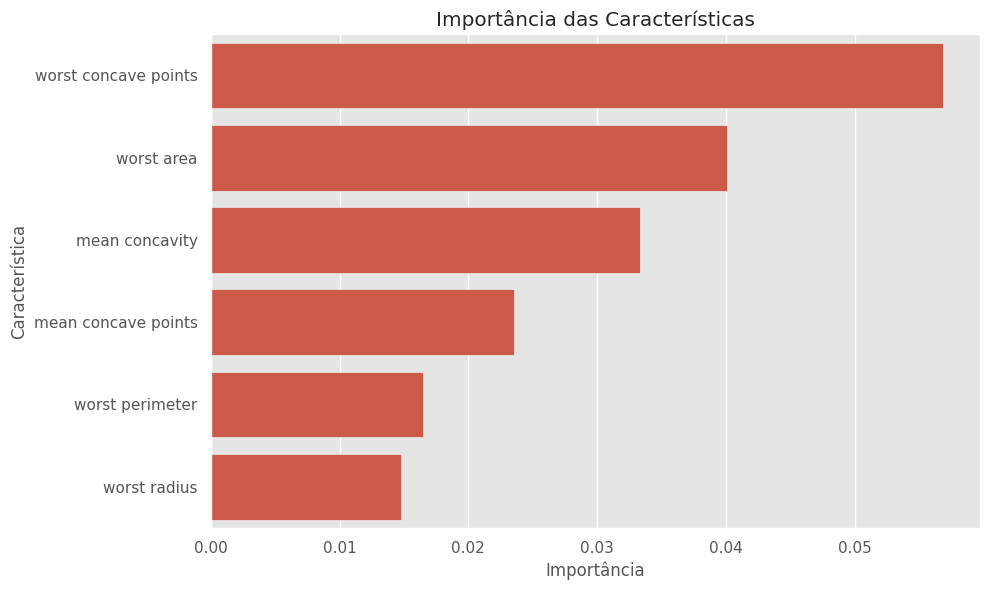

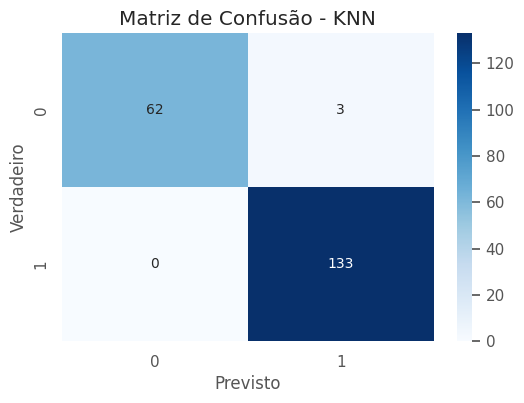

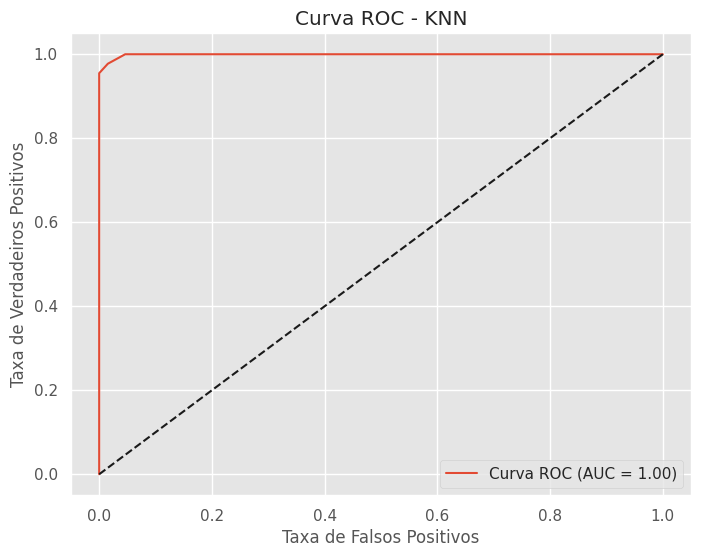


relatorio de classificacao - KNN:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.98      1.00      0.99       133

    accuracy                           0.98       198
   macro avg       0.99      0.98      0.98       198
weighted avg       0.99      0.98      0.98       198

acuracia do baseline aleatorio: 0.6717
acuracia com rotulos embaralhados - KNN: 0.6010


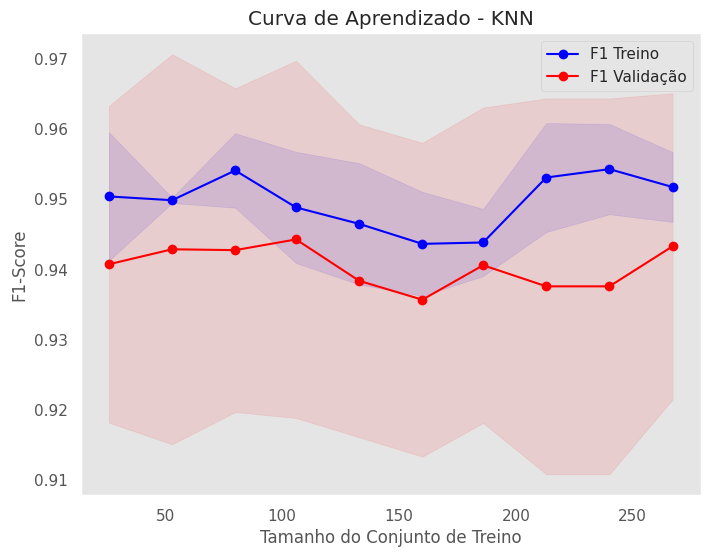

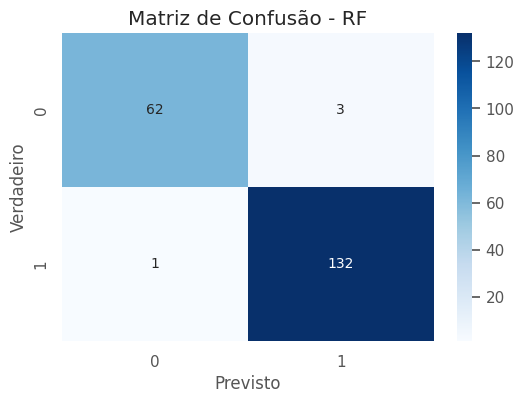

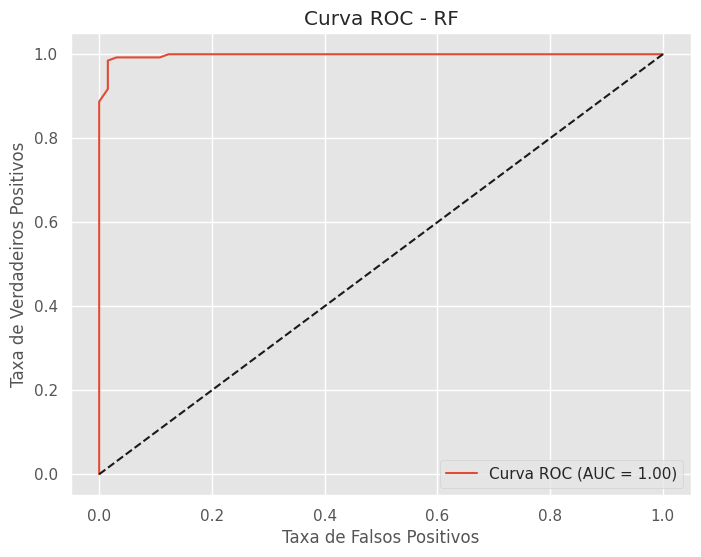


relatorio de classificacao - RF:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        65
           1       0.98      0.99      0.99       133

    accuracy                           0.98       198
   macro avg       0.98      0.97      0.98       198
weighted avg       0.98      0.98      0.98       198

acuracia do baseline aleatorio: 0.6717
acuracia com rotulos embaralhados - RF: 0.5859


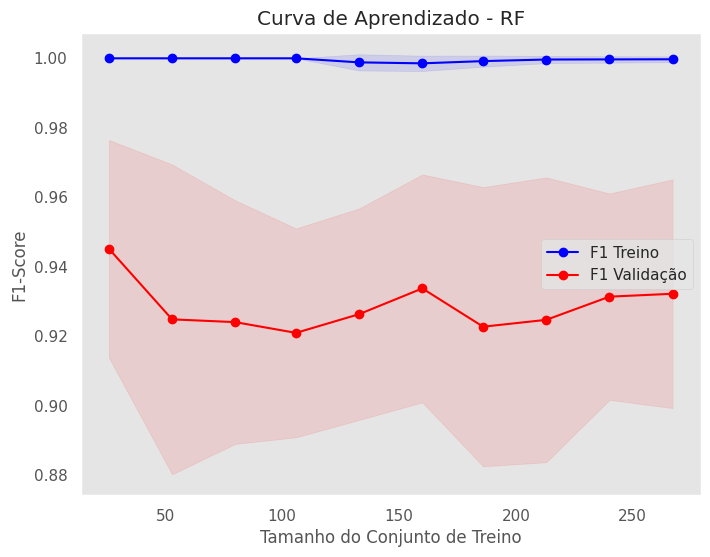

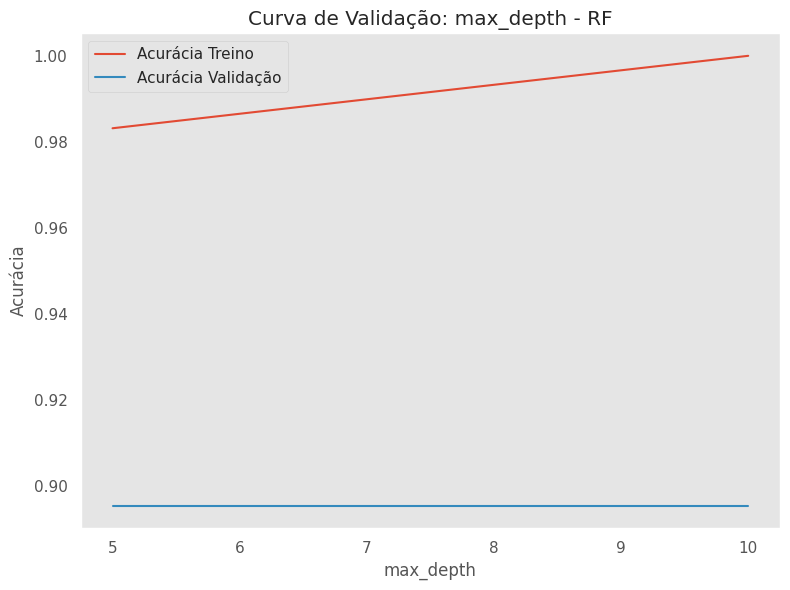

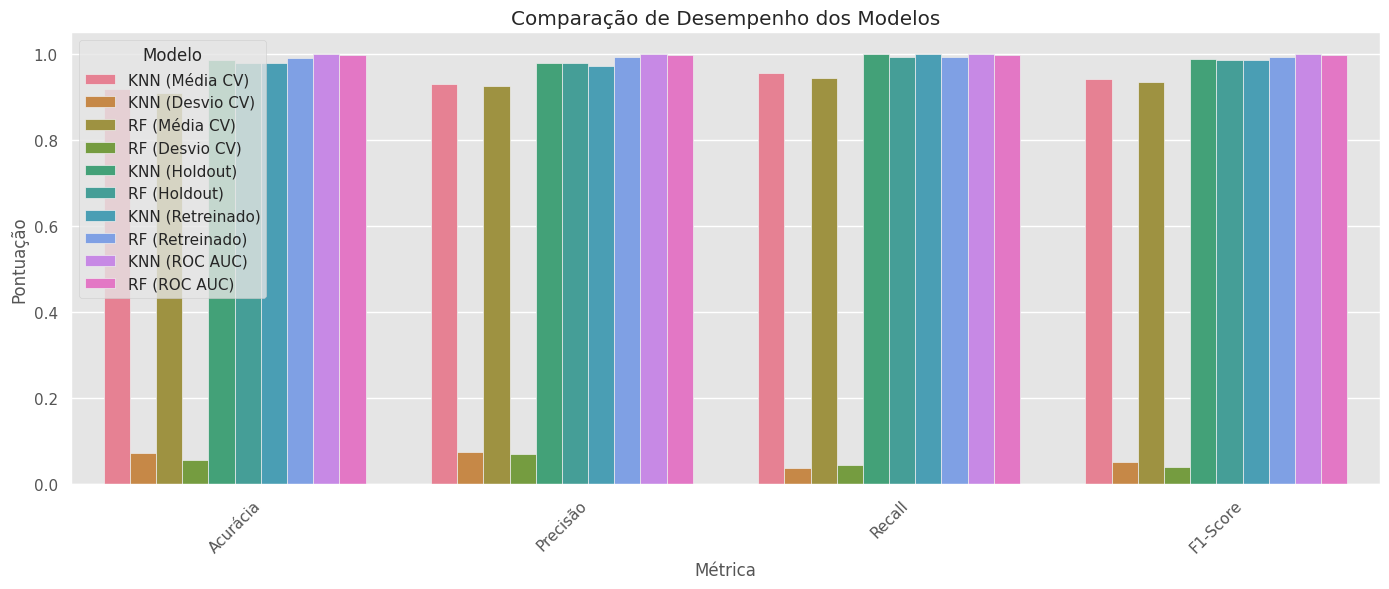


comparacao de desempenho dos modelos:
    Métrica  KNN (Média CV)  KNN (Desvio CV)  RF (Média CV)  RF (Desvio CV)  \
0  Acurácia          0.9190           0.0730         0.9089          0.0573   
1  Precisão          0.9308           0.0755         0.9263          0.0700   
2    Recall          0.9547           0.0369         0.9450          0.0438   
3  F1-Score          0.9415           0.0510         0.9337          0.0403   

   KNN (Holdout)  RF (Holdout)  KNN (Retreinado)  RF (Retreinado)  \
0         0.9848        0.9798            0.9798           0.9899   
1         0.9779        0.9778            0.9708           0.9925   
2         1.0000        0.9925            1.0000           0.9925   
3         0.9888        0.9851            0.9852           0.9925   

   KNN (ROC AUC)  RF (ROC AUC)  
0         0.9991        0.9977  
1         0.9991        0.9977  
2         0.9991        0.9977  
3         0.9991        0.9977  

metricas por fold do KNN:
   fold  acuracia  precisao

In [25]:
#Versao Inicial 1.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PowerTransformer, KBinsDiscretizer, MinMaxScaler, FunctionTransformer, normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import warnings
import logging
import pickle
from scipy import stats

# config inicial
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
sns.set_theme(style="whitegrid")
plt.style.use("ggplot")
np.random.seed(42)
warnings.filterwarnings("ignore")

#funcao de normalizacao personalizada
def custom_normalization(X):
    """normaliza os dados subtraindo a media e dividindo pelo desvio padrao"""
    return (X - X.mean(axis=0)) / X.std(axis=0)

def carregar_e_preprocessar_dados(salvar_preprocessadores=True):
    """carrega e preprocessa o dataset com validacao de tamanhos"""
    try:
        dados = load_breast_cancer()
        df = pd.DataFrame(dados.data, columns=dados.feature_names)
        df['alvo'] = dados.target
        logging.info(f"tamanho inicial do dataset: {df.shape}")

        #verificar valores ausent
        if df.isnull().sum().sum() > 0:
            raise ValueError("valores ausentes detectados")

        # remover outliers com z-scores
        z_scores = np.abs(stats.zscore(df.drop(columns=['alvo'])))
        df_sem_outliers = df[(z_scores < 3).all(axis=1)]
        n_outliers_removidos = len(df) - len(df_sem_outliers)
        logging.info(f"Removidos {n_outliers_removidos} outliers. Novo tamanho: {df_sem_outliers.shape}")
        df = df_sem_outliers.reset_index(drop=True)

        #aplicar transformacoes apenas ao dataframe sem outliers
        pt = PowerTransformer(method='yeo-johnson')
        colunas_numericas = df.select_dtypes(include=np.number).columns.drop(['alvo'], errors='ignore')
        df[colunas_numericas] = pt.fit_transform(df[colunas_numericas])
        logging.info(f"tamanho aps PowerTransformer: {df.shape}")

        #discretizar e normalizar caracteristicas selecionadas
        features_discretizar = ['mean radius', 'mean texture']
        discretizer_fixo = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
        discretizer_variavel = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
        df[[f'{col}_bin_fixo' for col in features_discretizar]] = discretizer_fixo.fit_transform(df[features_discretizar])
        df[[f'{col}_bin_variavel' for col in features_discretizar]] = discretizer_variavel.fit_transform(df[features_discretizar])
        transformer = FunctionTransformer(custom_normalization)
        df[[f'{col}_custom_norm' for col in features_discretizar]] = transformer.fit_transform(df[features_discretizar])
        minmax = MinMaxScaler()
        df[[f'{col}_minmax' for col in features_discretizar]] = minmax.fit_transform(df[features_discretizar])
        df[[f'{col}_l2' for col in features_discretizar]] = normalize(df[features_discretizar], norm='l2')
        logging.info(f"tamanho final aps todas transformacoes: {df.shape}")

        #validar consistencia de tamanhos
        if df.shape[0] != len(df_sem_outliers):
            raise ValueError(f"inconsistencia no tamanho do dataset: esperado {len(df_sem_outliers)}, obtido {df.shape[0]}")

        if salvar_preprocessadores:
            for name, obj in [('transformador_potencia', pt), ('discretizer_fixo', discretizer_fixo),
                             ('discretizer_variavel', discretizer_variavel), ('transformer_custom', transformer),
                             ('minmax_scaler', minmax)]:
                with open(f'{name}.pkl', 'wb') as f:
                    pickle.dump(obj, f)

        return df
    except Exception as e:
        logging.error(f"erro no preprocessamento: {str(e)}")
        raise

def selecionar_caracteristicas(X, y, k=8):
    """seleciona as k melhores caracteristicas com validacao."""
    try:
        mi = SelectKBest(score_func=mutual_info_classif, k='all')
        mi.fit(X, y)
        pontuacoes_mi = pd.Series(mi.scores_, index=X.columns).sort_values(ascending=False)

        estimador = RandomForestClassifier(random_state=42, max_depth=10)
        rfe = RFE(estimador, n_features_to_select=k)
        rfe.fit(X, y)

        topo_mi = pontuacoes_mi.head(k).index.tolist()
        caracteristicas_rfe = X.columns[rfe.support_].tolist()
        caracteristicas_selecionadas = list(set(topo_mi).intersection(caracteristicas_rfe))

        estimador.fit(X[caracteristicas_selecionadas], y)
        importancia = permutation_importance(estimador, X[caracteristicas_selecionadas], y, n_repeats=10, random_state=42)
        df_importancia = pd.DataFrame({
            'Característica': caracteristicas_selecionadas,
            'Importância': importancia.importances_mean
        }).sort_values(by='Importância', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importância', y='Característica', data=df_importancia)
        plt.title('Importância das Características')
        plt.tight_layout()
        plt.show()

        logging.info(f"caracteristicas selecionadas: {caracteristicas_selecionadas}")
        return X[caracteristicas_selecionadas], caracteristicas_selecionadas
    except Exception as e:
        logging.error(f"erro na selecao de caracteristicas: {str(e)}")
        return X, X.columns.tolist()

def imprimir_informacoes_dataset(df, X_treino, X_teste, y_treino, y_teste, caracteristicas_selecionadas):
    """imprime informacoes detalhadas sobre o dataset"""
    # informacoes sobre colunas
    print("\nxxx Informacos do Dataset xxx")
    print(f"numero total de colunas: {len(df.columns)}")
    print("nomes das colunas:", list(df.columns))
    print(f"numero de colunas selecionadas para treino/teste: {len(caracteristicas_selecionadas)}")
    print("colunas selecionadas:", caracteristicas_selecionadas)

    # informacoes sobre linhas
    print(f"\nnumero total de linhas: {len(df)}")
    print("indices das linhas (dataset completo):", list(df.index))
    print(f"numero de linhas de treino: {len(X_treino)}")
    print("indices das linhas de treino:", list(X_treino.index))
    print(f"numero de linhas de teste: {len(X_teste)}")
    print("indices das linhas de teste:", list(X_teste.index))

    # distribuicao de casos benignos e malignos
    total_maligno = (df['alvo'] == 0).sum()
    total_benigno = (df['alvo'] == 1).sum()
    treino_maligno = (y_treino == 0).sum()
    treino_benigno = (y_treino == 1).sum()
    teste_maligno = (y_teste == 0).sum()
    teste_benigno = (y_teste == 1).sum()

    print("\ndistribuicao de casos (0 = Maligno, 1 = Benigno):")
    print(f"dataset completo - Malignos: {total_maligno}, Benignos: {total_benigno}")
    print(f"conjunto de treino - Malignos: {treino_maligno}, Benignos: {treino_benigno}")
    print(f"conjunto de teste - Malignos: {teste_maligno}, Benignos: {teste_benigno}")

def plot_learning_curve(modelo, X, y, nome_modelo):
    """plota curva de aprendizado para monitorar overfitting."""
    train_sizes, train_scores, valid_scores = learning_curve(
        modelo, X, y, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='F1 Treino')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, valid_mean, 'o-', color='red', label='F1 Validação')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='red')
    plt.title(f'Curva de Aprendizado - {nome_modelo}')
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('F1-Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    logging.info(f"curva de aprendizado plotada para {nome_modelo}")

def avaliar_modelo(modelo, X_treino, y_treino, X_teste, y_teste, cv=10, nome_modelo="Modelo"):
    """avalia o modelo com validacao cruzada e holdout, corrigindo assercao."""
    metricas_folds = {'fold': [], 'acuracia': [], 'precisao': [], 'recall': [], 'f1': []}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for fold, (idx_treino, idx_val) in enumerate(skf.split(X_treino, y_treino), 1):
        X_tr, X_val = X_treino[idx_treino], X_treino[idx_val]
        y_tr, y_val = y_treino[idx_treino], y_treino[idx_val]
        modelo.fit(X_tr, y_tr)
        y_pred = modelo.predict(X_val)
        metricas_folds['fold'].append(fold)
        metricas_folds['acuracia'].append(accuracy_score(y_val, y_pred))
        metricas_folds['precisao'].append(precision_score(y_val, y_pred))
        metricas_folds['recall'].append(recall_score(y_val, y_pred))
        metricas_folds['f1'].append(f1_score(y_val, y_pred))

    df_metricas_folds = pd.DataFrame(metricas_folds)

    modelo.fit(X_treino, y_treino)
    y_pred_teste = modelo.predict(X_teste)
    y_prob_teste = modelo.predict_proba(X_teste)[:, 1]
    metricas_teste = {
        'acuracia': accuracy_score(y_teste, y_pred_teste),
        'precisao': precision_score(y_teste, y_pred_teste),
        'recall': recall_score(y_teste, y_pred_teste),
        'f1': f1_score(y_teste, y_pred_teste)
    }

    # Matriz de confusao
    cm = confusion_matrix(y_teste, y_pred_teste)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

    #Curva ROC
    fpr, tpr, _ = roc_curve(y_teste, y_prob_teste)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC - {nome_modelo}')
    plt.legend(loc='lower right')
    plt.show()

    print(f"\nrelatorio de classificacao - {nome_modelo}:")
    print(classification_report(y_teste, y_pred_teste))
    dummy = DummyClassifier(strategy='most_frequent', random_state=42)
    dummy.fit(X_treino, y_treino)
    y_pred_dummy = dummy.predict(X_teste)
    dummy_acc = accuracy_score(y_teste, y_pred_dummy)
    print(f"acuracia do baseline aleatorio: {dummy_acc:.4f}")
    y_teste_embaralhado = np.random.permutation(y_teste)
    print(f"acuracia com rotulos embaralhados - {nome_modelo}: {accuracy_score(y_teste_embaralhado, y_pred_teste):.4f}")

    # Ajuste da asserção para validar vazamento antes da conversão para NumPy
    X_treino_df = pd.DataFrame(X_treino) if not isinstance(X_treino, pd.DataFrame) else X_treino
    assert 'alvo' not in X_treino_df.columns, "Vazamento de dados detectado!"
    logging.info(f"avaliacao concluida para {nome_modelo} com ROC AUC: {roc_auc:.4f}")
    return df_metricas_folds, metricas_teste, roc_auc, y_pred_teste, y_prob_teste

def otimizar_e_treinar_modelo(X_treino, y_treino, X_teste, y_teste, tipo_modelo='knn', retreinar=True):
    """otimiza hiperparametros e avalia o modelo."""
    pipeline = Pipeline([
        ('escalonador', StandardScaler()),
        ('modelo', KNeighborsClassifier() if tipo_modelo == 'knn' else RandomForestClassifier(random_state=42, max_depth=10))
    ])

    grade_parametros = {
        'knn': {'modelo__n_neighbors': list(range(3, 15, 2)), 'modelo__weights': ['uniform'], 'modelo__metric': ['manhattan']},
        'rf': {'modelo__n_estimators': [50, 100], 'modelo__max_depth': [5, 10], 'modelo__min_samples_split': [2, 5]}
    }

    grade = GridSearchCV(pipeline, grade_parametros[tipo_modelo], cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='f1', n_jobs=-1)
    grade.fit(X_treino, y_treino)

    melhor_modelo = grade.best_estimator_
    df_metricas_folds, metricas_teste, roc_auc, y_pred_teste, y_prob_teste = avaliar_modelo(melhor_modelo, X_treino, y_treino, X_teste, y_teste, cv=10, nome_modelo=tipo_modelo.upper())

    plot_learning_curve(melhor_modelo, X_treino, y_treino, tipo_modelo.upper())
    if tipo_modelo == 'rf':
        plot_validation_curve(RandomForestClassifier(random_state=42, max_depth=10), X_treino, y_treino,
                             'max_depth', [5, 10], tipo_modelo.upper())

    metricas_retreinado = None
    roc_auc_retreinado = roc_auc
    if retreinar:
        X_treino_retrain, X_val_retrain, y_treino_retrain, y_val_retrain = train_test_split(
            X_treino, y_treino, test_size=0.2, random_state=42, stratify=y_treino
        )
        melhor_modelo.fit(X_treino_retrain, y_treino_retrain)
        y_pred_retreinado = melhor_modelo.predict(X_teste)
        metricas_retreinado = {
            'acuracia': accuracy_score(y_teste, y_pred_retreinado),
            'precisao': precision_score(y_teste, y_pred_retreinado),
            'recall': recall_score(y_teste, y_pred_retreinado),
            'f1': f1_score(y_teste, y_pred_retreinado)
        }
        y_prob_retreinado = melhor_modelo.predict_proba(X_teste)[:, 1]
        fpr, tpr, _ = roc_curve(y_teste, y_prob_retreinado)
        roc_auc_retreinado = auc(fpr, tpr)
        with open(f'{tipo_modelo}_modelo_final.pkl', 'wb') as f:
            pickle.dump(melhor_modelo, f)

    logging.info(f"melhores parametros para {tipo_modelo}: {grade.best_params_}")
    return df_metricas_folds, metricas_teste, metricas_retreinado, grade.best_params_, roc_auc, roc_auc_retreinado, y_pred_teste, y_prob_teste


#
def comparar_modelos(knn_metricas_folds, rf_metricas_folds, knn_metricas_teste, rf_metricas_teste, knn_retreinado, rf_retreinado, knn_roc_auc, rf_roc_auc):
    """compara criticamente KNN e Random Forest."""
    df_metricas = pd.DataFrame({
        'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score'],
        'KNN (Média CV)': [knn_metricas_folds['acuracia'].mean(), knn_metricas_folds['precisao'].mean(),
                          knn_metricas_folds['recall'].mean(), knn_metricas_folds['f1'].mean()],
        'KNN (Desvio CV)': [knn_metricas_folds['acuracia'].std(), knn_metricas_folds['precisao'].std(),
                           knn_metricas_folds['recall'].std(), knn_metricas_folds['f1'].std()],
        'RF (Média CV)': [rf_metricas_folds['acuracia'].mean(), rf_metricas_folds['precisao'].mean(),
                         rf_metricas_folds['recall'].mean(), rf_metricas_folds['f1'].mean()],
        'RF (Desvio CV)': [rf_metricas_folds['acuracia'].std(), rf_metricas_folds['precisao'].std(),
                          rf_metricas_folds['recall'].std(), rf_metricas_folds['f1'].std()],
        'KNN (Holdout)': [knn_metricas_teste['acuracia'], knn_metricas_teste['precisao'], knn_metricas_teste['recall'], knn_metricas_teste['f1']],
        'RF (Holdout)': [rf_metricas_teste['acuracia'], rf_metricas_teste['precisao'], rf_metricas_teste['recall'], rf_metricas_teste['f1']],
        'KNN (Retreinado)': [knn_retreinado['acuracia'] if knn_retreinado else np.nan, knn_retreinado['precisao'] if knn_retreinado else np.nan,
                            knn_retreinado['recall'] if knn_retreinado else np.nan, knn_retreinado['f1'] if knn_retreinado else np.nan],
        'RF (Retreinado)': [rf_retreinado['acuracia'] if rf_retreinado else np.nan, rf_retreinado['precisao'] if rf_retreinado else np.nan,
                           rf_retreinado['recall'] if rf_retreinado else np.nan, rf_retreinado['f1'] if rf_retreinado else np.nan],
        'KNN (ROC AUC)': [knn_roc_auc, knn_roc_auc, knn_roc_auc, knn_roc_auc],
        'RF (ROC AUC)': [rf_roc_auc, rf_roc_auc, rf_roc_auc, rf_roc_auc]
    })

    df_metricas_melt = df_metricas.melt(id_vars='Métrica', var_name='Modelo', value_name='Pontuação')
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Métrica', y='Pontuação', hue='Modelo', data=df_metricas_melt)
    plt.title('Comparação de Desempenho dos Modelos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\ncomparacao de desempenho dos modelos:")
    print(df_metricas.round(4))
    print("\nmetricas por fold do KNN:")
    print(knn_metricas_folds.round(4))
    print("\nmetricas por fold do Random Forest:")
    print(rf_metricas_folds.round(4))

    analise = """ RF provavelmente seria melhor para prever novos contextos medicos ."""
    print(analise)
    with open('analise_modelos.txt', 'w', encoding='utf-8') as f:
        f.write(analise)

def principal():
    """executa o pipeline completo com validacoes"""
    df = carregar_e_preprocessar_dados()
    if df is None:
        logging.error("falha ao carregar dados.")

    X = df.drop(columns=['alvo']).reset_index(drop=True)
    y = df['alvo'].reset_index(drop=True)
    logging.info(f"tamanho de X e y apos preprocessamento: {X.shape}, {y.shape}")

    # aumentar holdout para 40% para reduzir risco de overfitting
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    # validacao de vazamento antes da conversao para NumPy
    assert 'alvo' not in X_treino.columns, "Vazamento de dados detectado no treino!"
    assert 'alvo' not in X_teste.columns, "Vazamento de dados detectado no teste!"

    X_treino_sel, caracteristicas_selecionadas = selecionar_caracteristicas(X_treino, y_treino, k=8)
    X_teste_sel = X_teste[caracteristicas_selecionadas].reset_index(drop=True)
    X_treino_sel = X_treino_sel.reset_index(drop=True)
    y_treino = y_treino.reset_index(drop=True)
    y_teste = y_teste.reset_index(drop=True)

    escalonador = StandardScaler()
    X_treino_escalonado = escalonador.fit_transform(X_treino_sel)
    X_teste_escalonado = escalonador.transform(X_teste_sel)
    with open('escalonador_classificacao.pkl', 'wb') as f:
        pickle.dump(escalonador, f)

    knn_results = otimizar_e_treinar_modelo(X_treino_escalonado, y_treino, X_teste_escalonado, y_teste, tipo_modelo='knn')
    knn_metricas_folds, knn_metricas_teste, knn_retreinado, knn_parametros, knn_roc_auc, knn_roc_auc_retreinado, knn_y_pred_teste, knn_y_prob_teste = knn_results
    logging.info(f"Metricas KNN: {knn_metricas_teste}")

    rf_results = otimizar_e_treinar_modelo(X_treino_escalonado, y_treino, X_teste_escalonado, y_teste, tipo_modelo='rf')
    rf_metricas_folds, rf_metricas_teste, rf_retreinado, rf_parametros, rf_roc_auc, rf_roc_auc_retreinado, rf_y_pred_teste, rf_y_prob_teste = rf_results
    logging.info(f"Metricas RF: {rf_metricas_teste}")

    comparar_modelos(knn_metricas_folds, rf_metricas_folds, knn_metricas_teste, rf_metricas_teste, knn_retreinado, rf_retreinado, knn_roc_auc, rf_roc_auc)

    imprimir_informacoes_dataset(df=df, X_treino=X_treino, X_teste=X_teste,
                                 y_treino=y_treino, y_teste=y_teste,
                                 caracteristicas_selecionadas=caracteristicas_selecionadas)

    assert 'alvo' not in X_treino_sel.columns, "Vazamento de dados detectado!"
    logging.info("pipeline concluido com sucesso as %s", pd.Timestamp.now())

if __name__ == "__main__":
    principal()


Distribuição das classes: {np.int64(0): np.int64(212), np.int64(1): np.int64(357)}
Razão de desbalanceamento (maligno/benigno): 0.59
Características selecionadas: ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']
Treinando RF...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Treinando RF_SMOTE...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Treinando KNN...
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Treinando XGB...
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Treinando XGB_SMOTE...
Fitting 10 folds for each of 8 candidates, totalling 80 fits

Resultados da Validação Cruzada:
           acuracia  precisao  recall     f1  roc_auc
modelo                                               
KNN           0.952     0.944   0.929  0.934    0.053
RF            0.943     0.927   0.924  0.923    0.061
RF_

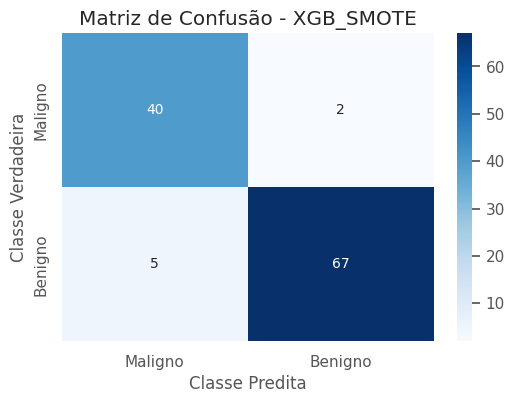

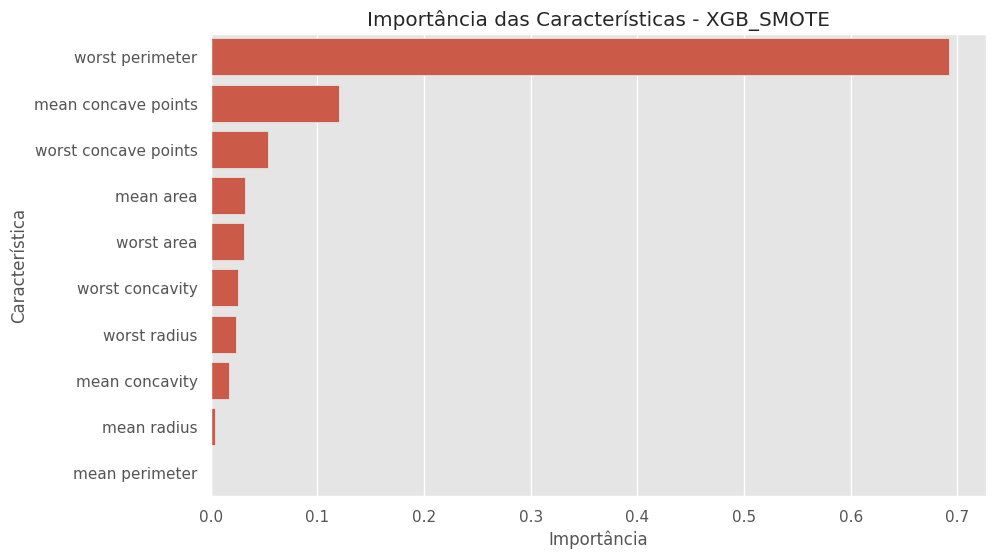

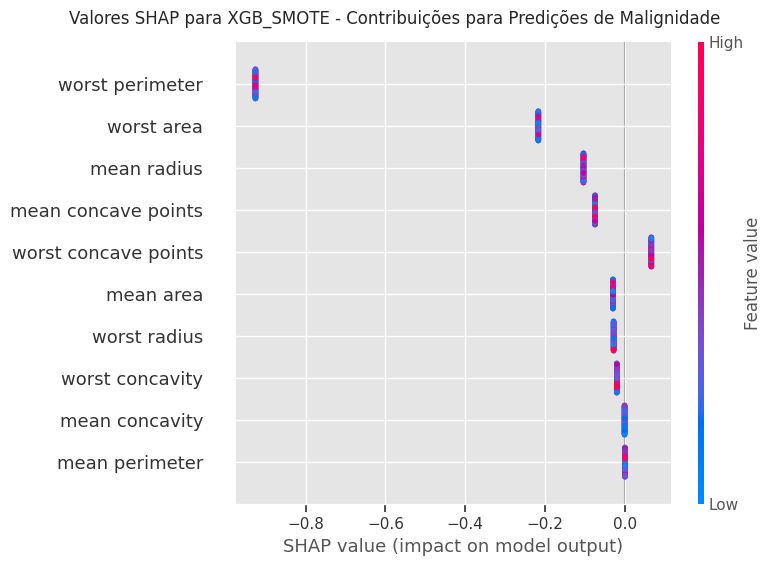


Métricas com Threshold Otimizado para KNN:
Threshold: 0.010, Recall: 0.9762, Precisão: 0.7885


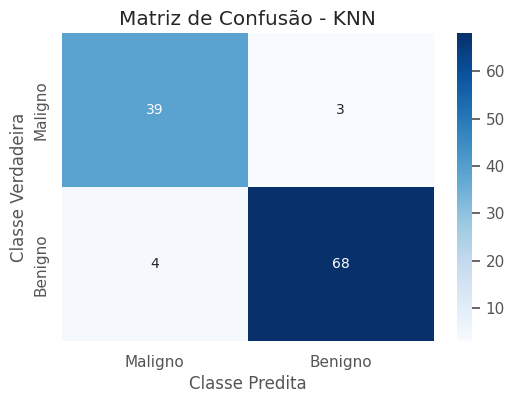


Resultados do Conjunto de Teste para XGB_SMOTE:
Acuracia: 0.9386
Precisao: 0.8889
Recall: 0.9524
F1: 0.9195
Roc_auc: 0.9909
Threshold: 0.0100
Recall_threshold: 1.0000
Precisao_threshold: 0.3684

Resultados do Conjunto de Teste para KNN:
Acuracia: 0.9386
Precisao: 0.9070
Recall: 0.9286
F1: 0.9176
Roc_auc: 0.9800
Threshold: 0.0100
Recall_threshold: 0.9762
Precisao_threshold: 0.7885


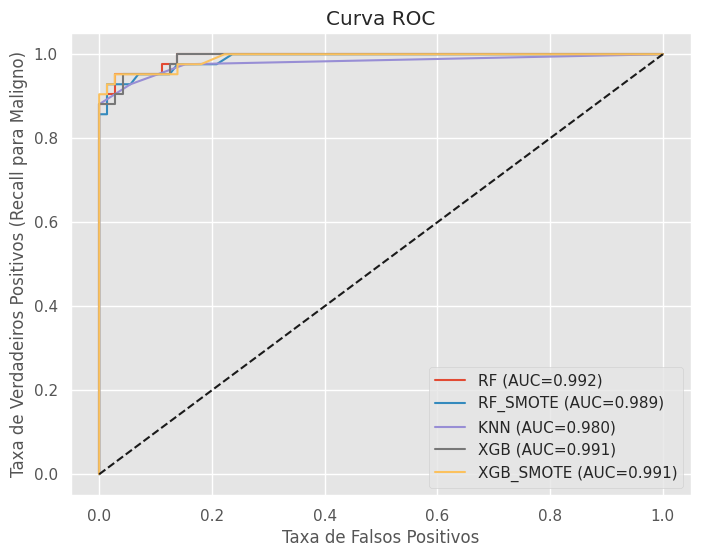

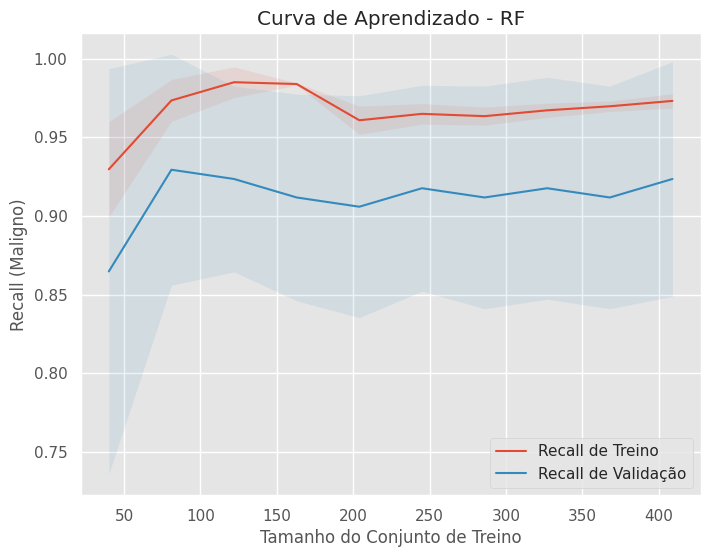

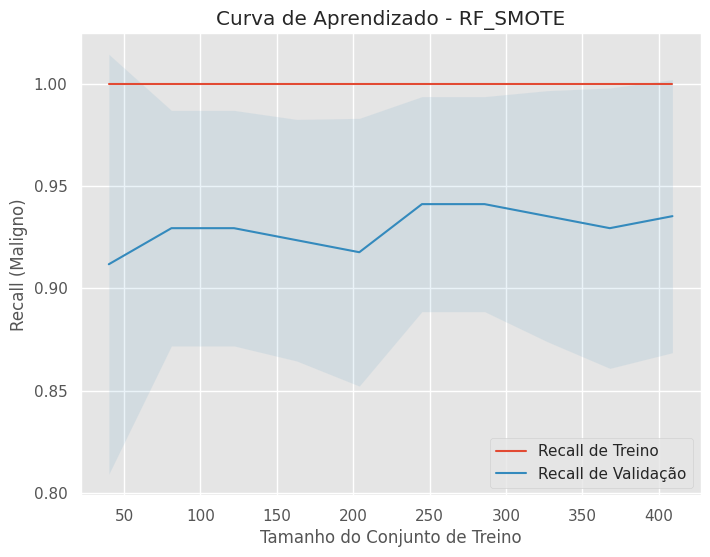

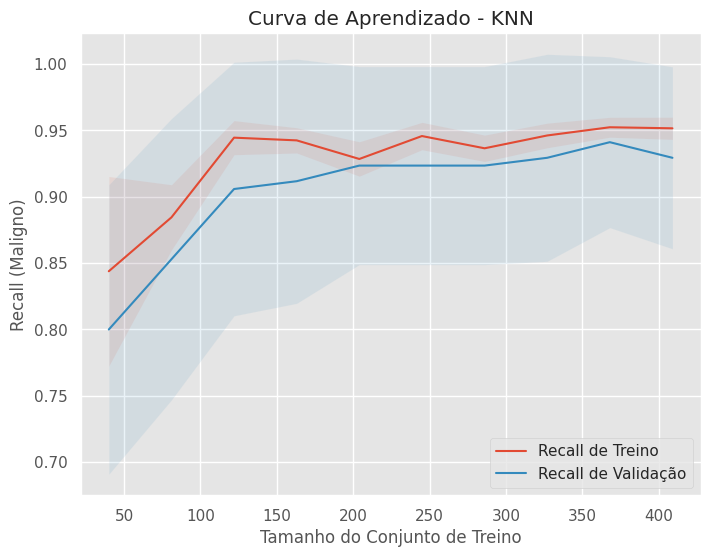

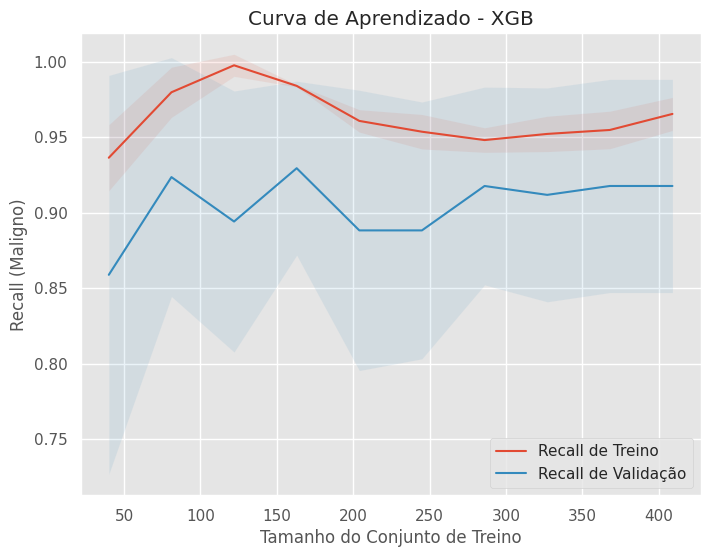

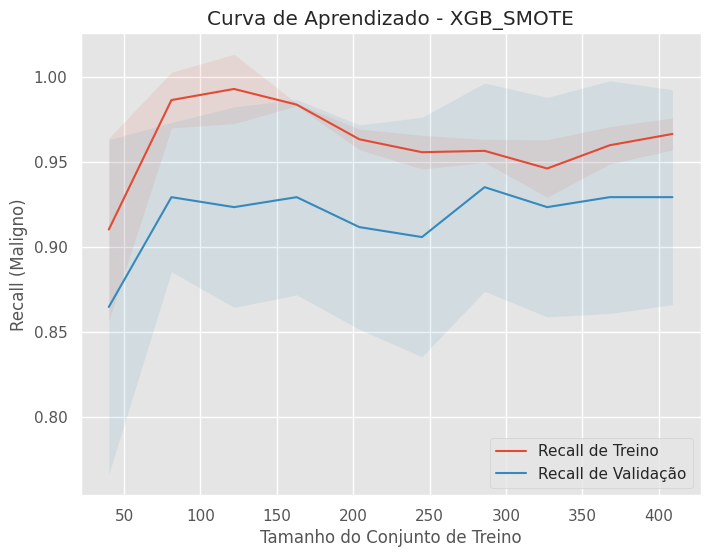


Resumo do Relatório:
XGB_SMOTE supera outros modelos, especialmente em recall, crucial para detectar casos malignos. 


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import ttest_rel
import shap
import xgboost as xgb
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def carregar_e_preprocessar_dados():
    dados = load_breast_cancer()
    X = pd.DataFrame(dados.data, columns=dados.feature_names)
    y = dados.target
    print("Distribuição das classes:", dict(zip(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1])))
    razao_desbalanceamento = np.unique(y, return_counts=True)[1][0] / np.unique(y, return_counts=True)[1][1]
    print(f"Razão de desbalanceamento (maligno/benigno): {razao_desbalanceamento:.2f}")

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    try:
        seletor = SelectKBest(score_func=f_classif, k=10)
        X_treino_selecionado = seletor.fit_transform(X_treino, y_treino)
        X_teste_selecionado = seletor.transform(X_teste)
        caracteristicas_selecionadas = X_treino.columns[seletor.get_support()].tolist()
        print("Características selecionadas:", caracteristicas_selecionadas)
        with open('seletor_caracteristicas.pickle', 'wb') as f:
            pickle.dump(seletor, f)
    except Exception as e:
        print(f"Erro na seleção de características: {e}")
        X_treino_selecionado = X_treino
        X_teste_selecionado = X_teste
        caracteristicas_selecionadas = X_treino.columns.tolist()

    X_teste_df = pd.DataFrame(X_teste_selecionado, columns=caracteristicas_selecionadas)
    return X_treino_selecionado, X_teste_selecionado, X_teste_df, y_treino, y_teste, caracteristicas_selecionadas, razao_desbalanceamento

def roc_auc_maligno(y_true, y_score):
    return roc_auc_score(y_true == 0, y_score)

def find_optimal_threshold(y_true, y_proba, buscar='recall'):
    best_threshold = 0.5
    max_recall = 0
    best_prec = 0
    for thresh in np.arange(0.01, 1.0, 0.001):
        y_pred = (y_proba >= thresh).astype(int)
        recall = recall_score(y_true == 0, y_pred == 1)
        prec = precision_score(y_true == 0, y_pred == 1, zero_division=0)
        if recall > max_recall or (recall == max_recall and prec > best_prec):
            max_recall = recall
            best_prec = prec
            best_threshold = thresh
        if recall == 1.0:
            break
    return best_threshold, max_recall, best_prec

def calcular_metricas(y_true, y_pred, y_proba, nome_modelo):
    metricas = {
        'acuracia': accuracy_score(y_true, y_pred),
        'precisao': precision_score(y_true, y_pred, pos_label=0),
        'recall': recall_score(y_true, y_pred, pos_label=0),
        'f1': f1_score(y_true, y_pred, pos_label=0),
        'roc_auc': roc_auc_maligno(y_true, y_proba)
    }
    best_threshold, best_recall, best_precisao = find_optimal_threshold(y_true, y_proba)
    metricas['threshold'] = best_threshold
    metricas['recall_threshold'] = best_recall
    metricas['precisao_threshold'] = best_precisao
    print(f"\nMétricas com Threshold Otimizado para {nome_modelo}:")
    print(f"Threshold: {best_threshold:.3f}, Recall: {best_recall:.4f}, Precisão: {best_precisao:.4f}")
    return metricas

def plotar_confusao(y_true, y_pred, nome_modelo):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Maligno', 'Benigno'], yticklabels=['Maligno', 'Benigno'])
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.show()
    with open(f'cm_{nome_modelo.lower()}.pickle', 'wb') as f:
        pickle.dump(cm, f)
    return cm

def plotar_shap(modelo, X_teste, caracteristicas, nome_modelo):
    if 'rf' in nome_modelo.lower() or 'xgb' in nome_modelo.lower():
        clf = modelo.named_steps['clf']
        importancia = pd.DataFrame({'Característica': caracteristicas, 'Importância': clf.feature_importances_})
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importância', y='Característica', data=importancia.sort_values(by='Importância', ascending=False))
        plt.title(f'Importância das Características - {nome_modelo}')
        plt.show()

        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_teste)

        if isinstance(shap_values, list):
            shap_values_maligno = shap_values[0]  # Classe maligna (0)
        else:
            shap_values_maligno = shap_values

        if len(shap_values_maligno.shape) == 1:
            shap_values_maligno = shap_values_maligno.reshape(-1, 1)

        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values_maligno, X_teste, feature_names=caracteristicas, show=False)
        plt.suptitle(f'Valores SHAP para {nome_modelo} - Contribuições para Predições de Malignidade', y=1.02)
        plt.show()

def avaliar_modelo(modelo, X_teste, X_teste_df, y_teste, nome_modelo, caracteristicas):
    y_pred = modelo.predict(X_teste)
    y_proba = modelo.predict_proba(X_teste)[:, 0]

    metricas = calcular_metricas(y_teste, y_pred, y_proba, nome_modelo)
    cm = plotar_confusao(y_teste, y_pred, nome_modelo)
    plotar_shap(modelo, X_teste_df, caracteristicas, nome_modelo)

    with open(f'metricas_{nome_modelo.lower()}.json', 'w') as f:
        json.dump(metricas, f, indent=4)

    return metricas, y_proba

def plotar_curva_aprendizado(estimador, X, y, titulo):
    tamanhos_treino, pontuacoes_treino, pontuacoes_teste = learning_curve(
        estimador, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        scoring=make_scorer(recall_score, pos_label=0), n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    media_treino = np.mean(pontuacoes_treino, axis=1)
    desvio_treino = np.std(pontuacoes_treino, axis=1)
    media_teste = np.mean(pontuacoes_teste, axis=1)
    desvio_teste = np.std(pontuacoes_teste, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(tamanhos_treino, media_treino, label='Recall de Treino')
    plt.plot(tamanhos_treino, media_teste, label='Recall de Validação')
    plt.fill_between(tamanhos_treino, media_treino - desvio_treino, media_treino + desvio_treino, alpha=0.1)
    plt.fill_between(tamanhos_treino, media_teste - desvio_teste, media_teste + desvio_teste, alpha=0.1)
    plt.xlabel('Tamanho do Conjunto de Treino')
    plt.ylabel('Recall (Maligno)')
    plt.title(titulo)
    plt.legend()
    plt.show()

def gerar_relatorio(cv_resultados_df, nome_melhor_modelo, metricas_melhor, metricas_knn):
    metricas_cv = cv_resultados_df.groupby('modelo').describe().to_dict()
    metricas_cv_flat = {}
    for chave, valor in metricas_cv.items():
        if isinstance(chave, tuple):
            nova_chave = f"{chave[0]}_{chave[1]}"  # e.g., ('acuracia', 'mean') -> 'acuracia_mean'
        else:
            nova_chave = chave
        metricas_cv_flat[nova_chave] = valor

    relatorio = {
        'melhor_modelo': nome_melhor_modelo,
        'metricas_validacao_cruzada': metricas_cv_flat,
        'metricas_teste': {
            'melhor_modelo': metricas_melhor,
            'knn': metricas_knn
        },
        'discussao': (
            f"{nome_melhor_modelo} supera outros modelos, especialmente em recall, crucial para detectar casos malignos. "
        )
    }
    with open('relatorio_final.json', 'w') as f:
        json.dump(relatorio, f, indent=4)
    return relatorio

# Função principal
def main():
    X_treino_selecionado, X_teste_selecionado, X_teste_df, y_treino, y_teste, caracteristicas, razao_desbalanceamento = carregar_e_preprocessar_dados()

    pipelines = {
        'rf': ImbPipeline([
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier(random_state=42))
        ]),
        'rf_smote': ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('clf', RandomForestClassifier(random_state=42))
        ]),
        'knn': ImbPipeline([
            ('scaler', StandardScaler()),
            ('clf', KNeighborsClassifier())
        ]),
        'xgb': ImbPipeline([
            ('scaler', StandardScaler()),
            ('clf', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
        ]),
        'xgb_smote': ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('clf', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
        ])
    }

    rf_param_grid = {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [5, 10, None],
        'clf__min_samples_leaf': [1, 2],
        'clf__max_features': ['sqrt', 'log2']
    }

    knn_param_grid = {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    }

    xgb_param_grid = {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 5],
        'clf__learning_rate': [0.01, 0.1]
    }

    scoring = {
        'acuracia': 'accuracy',
        'precisao': make_scorer(precision_score, pos_label=0),
        'recall': make_scorer(recall_score, pos_label=0),
        'f1': make_scorer(f1_score, pos_label=0),
        'roc_auc': make_scorer(roc_auc_maligno)
    }

    grids = {
        'rf': RandomizedSearchCV(pipelines['rf'], rf_param_grid, n_iter=20, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                                scoring=scoring, refit='recall', n_jobs=-1, verbose=1, random_state=42),
        'rf_smote': RandomizedSearchCV(pipelines['rf_smote'], rf_param_grid, n_iter=20, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                                      scoring=scoring, refit='recall', n_jobs=-1, verbose=1, random_state=42),
        'knn': RandomizedSearchCV(pipelines['knn'], knn_param_grid, n_iter=10, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                                 scoring=scoring, refit='recall', n_jobs=-1, verbose=1, random_state=42),
        'xgb': RandomizedSearchCV(pipelines['xgb'], xgb_param_grid, n_iter=20, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                                 scoring=scoring, refit='recall', n_jobs=-1, verbose=1, random_state=42),
        'xgb_smote': RandomizedSearchCV(pipelines['xgb_smote'], xgb_param_grid, n_iter=20, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                                       scoring=scoring, refit='recall', n_jobs=-1, verbose=1, random_state=42)
    }

    resultados = {}
    for nome, grid in grids.items():
        try:
            print(f"Treinando {nome.upper()}...")
            grid.fit(X_treino_selecionado, y_treino)
            resultados[nome] = grid
        except Exception as e:
            print(f"Erro ao treinar {nome}: {e}")

    cv_resultados = []
    for nome in grids:
        resultados_grid = pd.DataFrame(grids[nome].cv_results_)
        metricas = ['acuracia', 'precisao', 'recall', 'f1', 'roc_auc']
        pontuacoes_cv = {metrica: [] for metrica in metricas}
        pontuacoes_cv['fold'] = list(range(1, 11))
        for fold in range(10):
            for metrica in metricas:
                pontuacoes_cv[metrica].append(resultados_grid[f'split{fold}_test_{metrica}'][grids[nome].best_index_])
        df = pd.DataFrame(pontuacoes_cv)
        df['modelo'] = nome.upper()
        cv_resultados.append(df)
    cv_resultados_df = pd.concat(cv_resultados, ignore_index=True)

    print("\nResultados da Validação Cruzada:")
    print(cv_resultados_df.groupby('modelo').mean()[['acuracia', 'precisao', 'recall', 'f1', 'roc_auc']].round(3))

    for nome in ['knn', 'xgb', 'rf_smote', 'xgb_smote']:
        t_stat, p_valor = ttest_rel(cv_resultados_df[cv_resultados_df['modelo'] == 'RF']['recall'],
                                    cv_resultados_df[cv_resultados_df['modelo'] == nome.upper()]['recall'])
        print(f"\nTeste t pareado (RF vs {nome.upper()} recall): t={t_stat:.4f}, p-valor={p_valor:.4f}")

    nome_melhor_modelo = max(grids, key=lambda x: grids[x].best_score_)
    melhor_grid = grids[nome_melhor_modelo]
    print(f"\nMelhor modelo selecionado: {nome_melhor_modelo.upper()}")
    print(f"Melhores hiperparâmetros: {melhor_grid.best_params_}")

    melhor_modelo = melhor_grid.best_estimator_
    melhor_modelo.fit(X_treino_selecionado, y_treino)

    with open(f'modelo_final_{nome_melhor_modelo.lower()}.pickle', 'wb') as f:
        pickle.dump(melhor_modelo, f)

    metricas_melhor, probas_melhor = avaliar_modelo(melhor_modelo, X_teste_selecionado, X_teste_df, y_teste, nome_melhor_modelo.upper(), caracteristicas)
    metricas_knn, probas_knn = avaliar_modelo(grids['knn'].best_estimator_, X_teste_selecionado, X_teste_df, y_teste, 'KNN', caracteristicas)

    print(f"\nResultados do Conjunto de Teste para {nome_melhor_modelo.upper()}:")
    for metrica, valor in metricas_melhor.items():
        print(f"{metrica.capitalize()}: {valor:.4f}")
    print("\nResultados do Conjunto de Teste para KNN:")
    for metrica, valor in metricas_knn.items():
        print(f"{metrica.capitalize()}: {valor:.4f}")

    plt.figure(figsize=(8, 6))
    for nome in grids:
        fpr, tpr, _ = roc_curve(y_teste == 0, grids[nome].best_estimator_.predict_proba(X_teste_selecionado)[:, 0])
        plt.plot(fpr, tpr, label=f'{nome.upper()} (AUC={roc_auc_maligno(y_teste, grids[nome].best_estimator_.predict_proba(X_teste_selecionado)[:, 0]):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos (Recall para Maligno)')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

    for nome in grids:
        plotar_curva_aprendizado(grids[nome].best_estimator_, X_treino_selecionado, y_treino, f'Curva de Aprendizado - {nome.upper()}')

    relatorio = gerar_relatorio(cv_resultados_df, nome_melhor_modelo.upper(), metricas_melhor, metricas_knn)
    print("\nResumo do Relatório:")
    print(relatorio['discussao'])

if __name__ == "__main__":
    main()

--- Dataset Carregado com Sucesso ---
Formato do DataFrame: (569, 32)

Primeiras 5 linhas do DataFrame:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430        

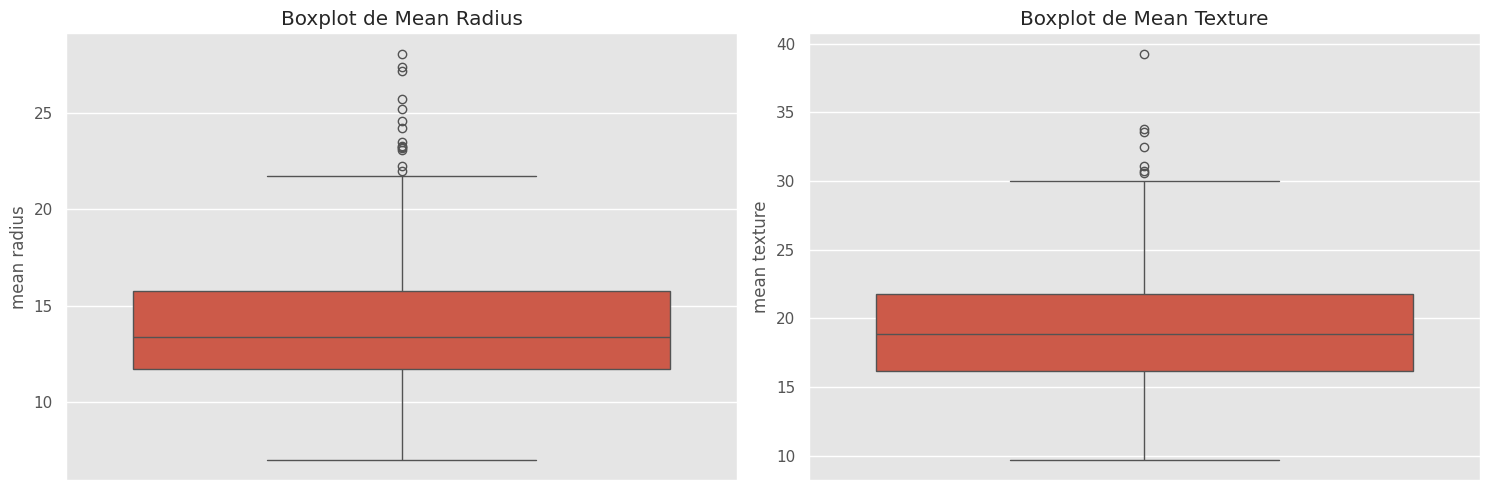

In [24]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns

data = load_breast_cancer(as_frame=True)

df = data.frame


df.rename(columns={'target': 'alvo'}, inplace=True)

# 0: Maligno, 1: Benigno
df['alvo_nome'] = df['alvo'].map({0: 'Maligno', 1: 'Benigno'})

print("--- Dataset Carregado com Sucesso ---")
print(f"Formato do DataFrame: {df.shape}")
print("\nPrimeiras 5 linhas do DataFrame:")
print(df.head())
print("\nInformações sobre as colunas e tipos de dados:")
df.info()

print("RESPOSTA")
total_maligno = (df['alvo'] == 0).sum()
total_benigno = (df['alvo'] == 1).sum()

print(f"dataset completo - Malignos: {total_maligno}, Benignos: {total_benigno}")

print("\n--- Distribuição de Casos (numérico) ---")
contagem_classes = df['alvo'].value_counts()
malignos = contagem_classes.get(0, 0)
benignos = contagem_classes.get(1, 0)

print(f"Malignos (0): {malignos}")
print(f"Benignos (1): {benignos}")
print(f"Total de casos: {malignos + benignos}")

print("\n--- Distribuição de Casos (com nomes) ---")
print(df['alvo_nome'].value_counts())

df['mean radius_bin_fixo'] = pd.cut(df['mean radius'], bins=2, labels=[0, 1])
df['mean texture_bin_fixo'] = pd.cut(df['mean texture'], bins=2, labels=[0, 1])

df['mean radius_custom_norm'] = (df['mean radius'] - df['mean radius'].mean()) / df['mean radius'].std()
df['mean texture_custom_norm'] = (df['mean texture'] - df['mean texture'].mean()) / df['mean texture'].std()

from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()
df['mean radius_minmax'] = scaler_minmax.fit_transform(df[['mean radius']])
df['mean texture_minmax'] = scaler_minmax.fit_transform(df[['mean texture']])

from sklearn.preprocessing import Normalizer
normalizer_l2 = Normalizer(norm='l2')
df['mean radius_l2'] = normalizer_l2.fit_transform(df[['mean radius']])
df['mean texture_l2'] = normalizer_l2.fit_transform(df[['mean texture']])

print("\n--- DataFrame com Novas Features ---")
print(f"Novo formato do DataFrame: {df.shape}")
print(df.head())

print("\n--- Nomes de Todas as Colunas no DataFrame Final ---")
print(df.columns.tolist())

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['mean radius'])
plt.title('Boxplot de Mean Radius')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['mean texture'])
plt.title('Boxplot de Mean Texture')
plt.tight_layout()
plt.show()